In [1]:
import os
import glob
import json
from itertools import product
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import mplhep as hep
plt.style.use(hep.style.ATLAS)
plt.rc('legend',fontsize='large')
plt.rc('axes',labelsize='x-large')
plt.rc('text',usetex='false')
plt.rc('xtick', labelsize='large')
import seaborn as sns
import joblib
from packages.constants import HOME_PATH, STEP_PREFIX
from packages.utils import get_electron_label, get_jet_label, get_et_eta_regions, get_logger
ET_BINS = [15.0,20.0,30.0,40.0,50.0,100.0,np.inf]
ETA_BINS = [0,0.8,1.37,1.54,2.37,2.5]
ET_ETA_REGIONS = get_et_eta_regions(ET_BINS, ETA_BINS)
%matplotlib inline

### Functions

In [2]:
def save_hists_df(hists_dict, output_dir, var, name):
    for hist_name, org_hist_df in hists_dict.items():
        source_name = hist_name.replace(' ', '_').lower()
        filepath = os.path.join(output_dir, f'{var}_{source_name}_{name}_hist.csv')
        org_hist_df.to_csv(filepath)
    return 0

In [3]:
def get_hist_df(hist, bins):
    hist_df_cols = ['bin_start', 'bin_end', 'hist']
    hist_df = pd.DataFrame(np.column_stack((bins[:-1], bins[1:], hist)), columns=hist_df_cols)
    return hist_df

In [4]:
def get_var_info(var: str):
    return VAR_INFOS.loc[VAR_INFOS['name']==var].iloc[0].to_dict()

In [5]:
def make_hist1d_plot(data: dict, var: str, ax, orientation='vertical', **kwargs):
    var_info = get_var_info(var)
    data_hists = dict()
    data_patches = dict()
    if not kwargs:
        default_dict = dict(range=None, bins=None)
        kwargs = dict.fromkeys(data.keys(), default_dict)
    for source_name, data_source in data.items():
        source_kwargs = kwargs[source_name]
        var_col = var_info['l2calo'] if not pd.isna(var_info['l2calo']) else var_info['TaP']
        n_samples = '{:.2e}'.format(int((~data_source[var_col].isnull()).sum()))
        hist, bins, data_patches[source_name] = ax.hist(data_source[var_col], 
            bins=source_kwargs['bins'], 
            range=source_kwargs['range'], 
            density=True, histtype='step', orientation=orientation,
            label=f'{source_name} {n_samples} samples')
        data_hists[source_name] = (hist, bins)
    return ax, data_hists, data_patches

In [6]:
def add_regions(df, et_bins, eta_bins, inplace=False):

    if inplace:
        df=df.copy()

    et_info = get_var_info('et')
    eta_info = get_var_info('eta')
    n_ets = len(et_bins)-1
    n_etas = len(eta_bins)-1

    et_labels = [str(et_bins[et_idx: et_idx+2]) for et_idx in range(n_ets)]
    et_intervals = pd.IntervalIndex.from_arrays(left=et_bins[:-1], right=et_bins[1:], closed='left')
    df[et_info['label']] =  pd.cut(df[et_info['l2calo']], bins=et_intervals)
    eta_labels = [str(eta_bins[eta_idx: eta_idx+2]) for eta_idx in range(n_etas)]
    eta_intervals = pd.IntervalIndex.from_arrays(left=eta_bins[:-1], right=eta_bins[1:], closed='left')
    df[eta_info['label']] =  pd.cut(df[eta_info['l2calo']].abs(), bins=eta_intervals)
    
    return df

In [7]:
def get_grid_matrix(nrows=1, ncols=1, sharex=True, sharey=True, **kwargs):
    fig, axes = plt.subplots(nrows, ncols, **kwargs)
    if ncols != 1 and sharey:
        for row in range(nrows):
            ax_0i = axes[row,0]
            for col in range(1, ncols):
                ax_0i.get_shared_y_axes().join(ax_0i, axes[row, col])
    
    if nrows != 1 and sharex:
        for col in range(ncols):
            ax_i0 = axes[0,col]
            for row in range(1, nrows):
                ax_i0.get_shared_x_axes().join(ax_i0, axes[row, col])
    return fig, axes

def grid_plot(data, var, plot_scale, et_bins, eta_bins, params, logger=None):
    if logger is None:
        logger = get_logger('plot_log', file=False)
    var_info = get_var_info(var)
    et_info = get_var_info('et')
    eta_info = get_var_info('eta')
    fig, axes = get_grid_matrix(5,6, sharex=True, sharey=False, figsize=(18,15), dpi=72)
    bin_idx = 0
    n_ets = len(et_bins)-1
    n_etas = len(eta_bins)-1
    et_eta_idxs = product(range(n_ets),range(n_etas))
    hists = np.empty((n_etas,n_ets), dtype=object)
    upper_ylim = np.empty((n_etas,n_ets), dtype=float)
    lower_ylim = np.empty((n_etas,n_ets), dtype=float)
    upper_xlim = np.empty((n_etas,n_ets), dtype=float)
    lower_xlim = np.empty((n_etas,n_ets), dtype=float)
    for et_idx, eta_idx in et_eta_idxs:
        et_range = ET_BINS[et_idx: et_idx+2]
        eta_range = ETA_BINS[eta_idx: eta_idx+2]
        logger.info(f'At bin {bin_idx} et_range {et_range} eta_range {eta_range}')
        bin_data = dict()
        for source_name, data_source in data.items():
            et_category = data_source[et_info['label']].cat.categories[et_idx]
            eta_category = data_source[eta_info['label']].cat.categories[eta_idx]
            in_et = data_source[et_info['label']] == et_category
            in_eta = data_source[eta_info['label']] == eta_category
            bin_df = data_source.loc[in_et&in_eta, [var_info['l2calo']]]
            if bin_df.empty:
                logger.warning(f'{source_name} bin_df is empty')
            bin_data[source_name] = bin_df
        
        ax = axes[eta_idx, et_idx]
        _, hists[eta_idx, et_idx], _ = make_hist1d_plot(bin_data, var, ax, **params)
        ax.set(yscale=plot_scale)
        lower_ylim[eta_idx, et_idx], upper_ylim[eta_idx, et_idx] = ax.get_ylim()
        lower_xlim[eta_idx, et_idx], upper_xlim[eta_idx, et_idx] = ax.get_xlim()
        sns.despine(ax=ax)
        if et_idx == 0:    #First col
            if eta_idx == n_etas-1:    #Last row
                ax.set_ylabel(f'${eta_range[0]} \leq |{eta_info["label"]}| \leq {eta_range[1]}$', ha='center', fontsize='large')
            else:
                ax.set_ylabel(f'${eta_range[0]} \leq |{eta_info["label"]}| < {eta_range[1]}$', ha='center', fontsize='large')

        if eta_idx == 0:    #First row
            if et_idx == n_ets-1:    #Last col
                ax.set_title(f'${et_range[0]} \leq {et_info["label"]} [GeV] \leq {et_range[1]}$', ha='center', fontsize='large')
            else:
                ax.set_title(f'${et_range[0]} \leq {et_info["label"]} [GeV] < {et_range[1]}$', ha='center', fontsize='large')

        bin_idx += 1
    
    # Making all y axis equal
    row_upper_lim = upper_ylim.max(axis=1)
    row_lower_lim = lower_ylim.min(axis=1)
    for eta_idx, upper, lower in zip(range(n_etas), row_upper_lim, row_lower_lim):
        for et_idx in range(n_ets):
            axes[eta_idx, et_idx].set_ylim(lower, upper)
    
    # Making all x axis equal
    col_upper_lim = upper_xlim.max(axis=0)
    col_lower_lim = lower_xlim.min(axis=0)
    for et_idx, upper, lower in zip(range(n_ets), col_upper_lim, col_lower_lim):
        for eta_idx in range(n_etas):
            axes[eta_idx, et_idx].set_xlim(lower, upper)

    for eta_idx, row in enumerate(axes):
        for et_idx, ax in enumerate(row):

            if et_idx == 0: #First col
                for ticklabel in ax.get_yticklabels():
                    ticklabel.set_fontsize('small')
            else:
                ax.set_yticklabels([])

            if eta_idx == n_etas-1:    #Last row
                for ticklabel in ax.get_xticklabels():
                    ticklabel.set_fontsize('small')
            else:
                ax.set_xticklabels([])

    fig.suptitle(f'{var_info["label"]} distribution per region', fontsize='xx-large', ha='center', va='top')
    fig.tight_layout()
    return fig, axes

### Loading data

In [8]:
plot_cols = list()
plot_logger = get_logger('plot_log', file=False)
step='L2Calo'
basepath = os.path.join('..', '..')
output_dir = os.path.join(basepath, 'analysis', 'vars_distributions')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
datapath = os.path.join(basepath, 'data')
VAR_INFOS = pd.read_csv(os.path.join(datapath, 'var_infos.csv'), index_col=0)
collision_path = os.path.join(datapath, 'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet')
#                              'ided_data17_13TeV.AllPeriods.sgn.probes_lhvloose_EGAM1.bkg.vprobes_vlhvloose_EGAM7.GRL_v97.25bins.parquet_et4_eta4.parquet')
boosted_path = os.path.join(datapath, 'ided_mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins.v2.parquet')

load_cols = VAR_INFOS.loc[VAR_INFOS['description'] == 'shower shape', 'l2calo'].to_list()
load_cols += VAR_INFOS.loc[VAR_INFOS['name'].isin(['et', 'eta']), 'l2calo'].to_list()
print(load_cols)
VAR_INFOS

['trig_L2_cl_reta', 'trig_L2_cl_eratio', 'trig_L2_cl_f1', 'trig_L2_cl_ehad1', 'trig_L2_cl_f3', 'trig_L2_cl_wstot', 'trig_L2_cl_weta2', 'trig_L2_cl_e2tsts1', 'trig_L2_cl_et', 'trig_L2_cl_eta']


,name,label,lower_lim,upper_lim,l2calo,offline,TaP,description
0,et,$E_T$,0.0,NaN,trig_L2_cl_et,el_et,NaN,tranevrse energy
1,eta,$\eta$,-2.5,2.5,trig_L2_cl_eta,el_eta,NaN,pseudovelocity
2,reta,$R_{\eta}$,0.0,1.0,trig_L2_cl_reta,el_reta,NaN,shower shape
3,eratio,$E_{ratio}$,0.0,1.0,trig_L2_cl_eratio,el_eratio,NaN,shower shape
4,f1,$f_1$,0.0,1.0,trig_L2_cl_f1,el_f1,NaN,shower shape
5,ehad1,$E_{had1}$,NaN,NaN,trig_L2_cl_ehad1,el_ehad1,NaN,shower shape
6,f3,$f_3$,0.0,1.0,trig_L2_cl_f3,el_f3,NaN,shower shape
7,wstot,$\omega_{stot}$,0.0,NaN,trig_L2_cl_wstot,el_wstot,NaN,shower shape
8,weta2,$\omega_{\eta 2}$,0.0,NaN,trig_L2_cl_weta2,el_weta2,NaN,shower shape
9,e2tsts1,e2tsts1,NaN,NaN,trig_L2_cl_e2tsts1,el_e2tsts1,NaN,shower shape


In [9]:
boosted_data = pd.read_parquet(boosted_path, columns=load_cols + ['el_TaP_deltaR'])
boosted_data['trig_L2_cl_et'] = boosted_data['trig_L2_cl_et']/1000
add_regions(boosted_data, ET_BINS, ETA_BINS)
boosted_data['source'] = 'MC16 Boosted el'
boosted_data['source'] = boosted_data['source'].astype('category')
boosted_data.head()

,trig_L2_cl_reta,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_ehad1,trig_L2_cl_f3,trig_L2_cl_wstot,trig_L2_cl_weta2,trig_L2_cl_e2tsts1,trig_L2_cl_et,trig_L2_cl_eta,el_TaP_deltaR,$E_T$,$\eta$,source
0,0.925877,0.982229,0.286768,1626.380493,0.004404,1.134755,0.010177,24.469589,17.387987,-0.334400,0.646720,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
1,0.988089,0.816197,0.085186,-184.739105,0.008879,1.250962,0.009084,59.001091,18.339359,-0.029264,0.549039,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
2,0.935216,0.890477,0.466089,-161.464890,-0.000920,2.881309,0.011774,198.510132,19.970226,0.278382,0.710056,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
3,0.962935,0.948033,0.320025,-130.190170,0.001840,1.323367,0.009567,67.998497,17.113560,0.618808,0.692156,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
4,0.670090,0.138930,0.270767,5028.686035,0.011920,6.128632,0.017711,846.002319,18.358532,-0.192658,2.330301,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el


In [10]:
start_time = datetime.now()
print(f'Start: {start_time}')
add_cols = ['target', 'el_lhmedium', 'el_lhvloose']
collision_data = pd.read_parquet(collision_path, columns=load_cols + add_cols)
read_time = datetime.now()
print(f'Time to read data {read_time-start_time}')
print(collision_data.shape)
jet_label = get_jet_label(collision_data, 'el_lhvloose')
el_label = get_electron_label(collision_data, 'el_lhmedium')
print(f'There are {jet_label.sum()} jets and {el_label.sum()} electrons')
label_time = datetime.now()
print(f'Time to labeling {label_time-read_time}')
print(f'Do electrons and jet have intersections? {(jet_label & el_label).any()}')
collision_data.drop(add_cols, axis=1, inplace=True)
el_data = collision_data.loc[el_label]
jet_data = collision_data.loc[jet_label]
del collision_data
#Converting MeV to GeV
el_data['trig_L2_cl_et'] = el_data['trig_L2_cl_et']/1000
jet_data['trig_L2_cl_et'] = jet_data['trig_L2_cl_et']/1000
el_data['source'] = 'Data17 Zee el'
el_data['source'] = el_data['source'].astype('category')
jet_data['source'] = 'Data17 Zee jet'
jet_data['source'] = jet_data['source'].astype('category')
drop_time = datetime.now()
print(f'Time to drop {drop_time-label_time}')
add_regions(el_data, ET_BINS, ETA_BINS)
add_regions(jet_data, ET_BINS, ETA_BINS)
end_time = datetime.now()
print(f'Time to add regions {end_time-drop_time}')
el_data.head()

Start: 2022-09-22 21:10:00.903199
Time to read data 0:00:39.458266
(43311283, 13)
There are 10906928 jets and 28955057 electrons
Time to labeling 0:00:00.340457
Do electrons and jet have intersections? False
Time to drop 0:00:08.868586
Time to add regions 0:00:53.113489


,trig_L2_cl_reta,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_ehad1,trig_L2_cl_f3,trig_L2_cl_wstot,trig_L2_cl_weta2,trig_L2_cl_e2tsts1,trig_L2_cl_et,trig_L2_cl_eta,source,$E_T$,$\eta$
0,0.972962,0.948686,0.388993,-190.000000,0.008554,1.520756,0.009378,60.406715,19.273964,0.099392,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"
1,0.953338,0.948622,0.321716,-39.500000,0.003106,1.440343,0.009217,60.253700,19.330248,0.264886,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"
2,1.013074,0.883187,0.487872,-249.500000,0.002307,1.515310,0.008863,147.912476,15.270059,-0.249952,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"
3,1.028176,0.926765,0.426812,148.000000,-0.000522,2.569318,0.010547,117.116714,17.340075,0.582413,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"
4,1.061034,0.974475,0.404273,711.230164,-0.000863,2.097330,0.009515,23.086594,15.489010,-0.697643,Data17 Zee el,"[15.0, 20.0)","[0.0, 0.8)"


In [ ]:
# data = {pd.concat([boosted_data, el_data, jet_data])
# del boosted_data, jet_data, el_data
# data.head()}
data = {
    'MC16 Boosted el': boosted_data,
    'Data17 Zee el': el_data,
    'Data17 Zee jet': jet_data
}

In [11]:
# data = pd.concat([boosted_data, el_data, jet_data], axis=0)
# del boosted_data, el_data, jet_data
# data.head()

,trig_L2_cl_reta,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_ehad1,trig_L2_cl_f3,trig_L2_cl_wstot,trig_L2_cl_weta2,trig_L2_cl_e2tsts1,trig_L2_cl_et,trig_L2_cl_eta,el_TaP_deltaR,$E_T$,$\eta$,source
0,0.925877,0.982229,0.286768,1626.380493,0.004404,1.134755,0.010177,24.469589,17.387987,-0.334400,0.646720,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
1,0.988089,0.816197,0.085186,-184.739105,0.008879,1.250962,0.009084,59.001091,18.339359,-0.029264,0.549039,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
2,0.935216,0.890477,0.466089,-161.464890,-0.000920,2.881309,0.011774,198.510132,19.970226,0.278382,0.710056,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
3,0.962935,0.948033,0.320025,-130.190170,0.001840,1.323367,0.009567,67.998497,17.113560,0.618808,0.692156,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el
4,0.670090,0.138930,0.270767,5028.686035,0.011920,6.128632,0.017711,846.002319,18.358532,-0.192658,2.330301,"[15.0, 20.0)","[0.0, 0.8)",MC16 Boosted el


## 1D Hist plots

### $E_{ratio}$

This shower shape is a ratio. The numerator is the difference between the biggest and the second biggest energy deposits on EM1 inside the cluster. The denominator is the sum of these energies. This way the shower shape should be limited to the [0,1] interval. However, there were values bigger than 1, which were considered problematic samples and removed from plots.

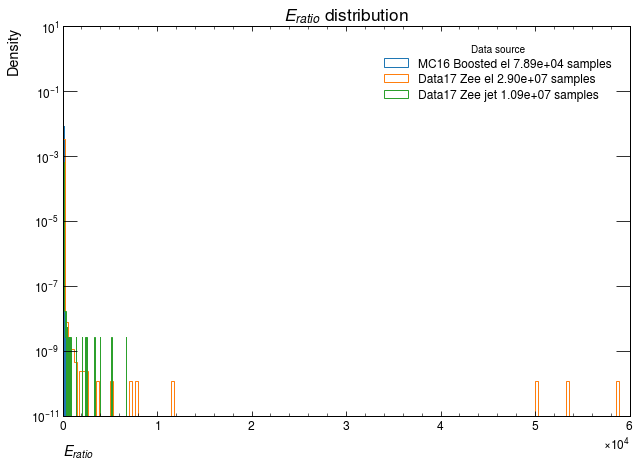

In [98]:
var='eratio'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=None, bins=200))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)

ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'], loc='left')
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')

# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))

fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 20:47:01,075 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 20:47:01,151 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 20:47:01,216 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 20:47:01,277 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 20:47:01,349 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 20:47:01,403 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 20:47:01,530 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 20:47:01,633 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 20:47:01,699 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 20:47:01,807 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 20:47:01,867 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 20:47:02,178 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 20:47:02,357 - At bin 12 et_range [30.0, 40.

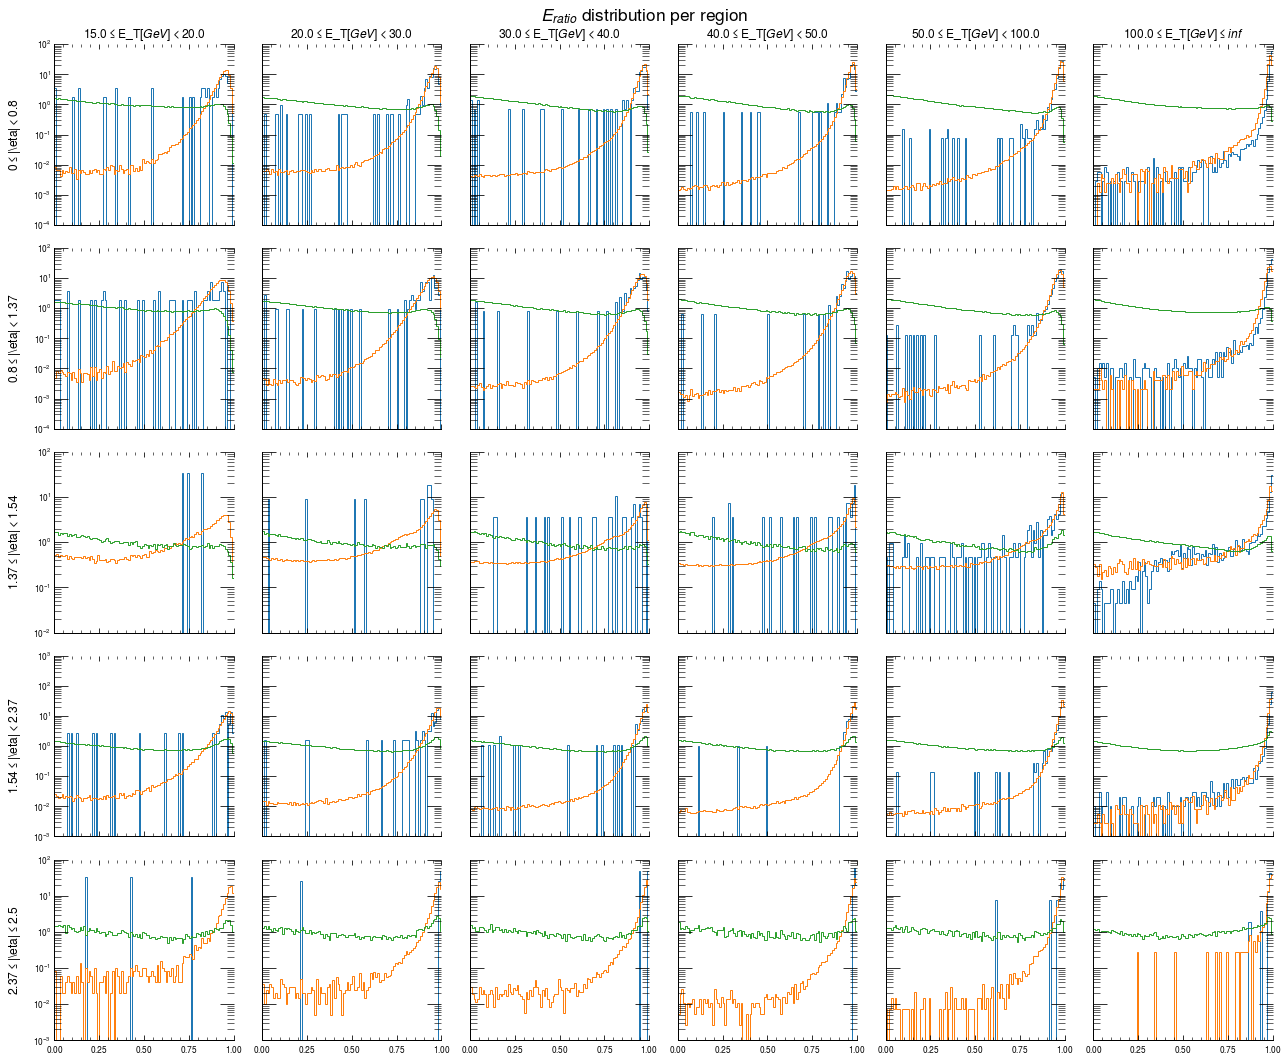

In [55]:
var='eratio'
plot_scale = 'log'
params = {
    'MC16 Boosted el':{
        'bins': 100,
        'range':(0,1)
    },
    'Data17 Zee el':{
        'bins': 100,
        'range':(0,1)
    },
    'Data17 Zee jet':{
        'bins': 100,
        'range':(0,1)
    }
}
row_lower_limits = [1e-4, 1e-4, 1e-2, 1e-3, 1e-3]
row_upper_limits = [1e2 for _ in range(len(row_lower_limits))]
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $R_{\eta}$
This shower shape is a ratio between Energy in 3x7 region by 7x7 region (The regions are $\eta$ x $\phi$). This way the shower shape should be limited to the [0,1] interval. However there were values bigger than 1 that were discarded.

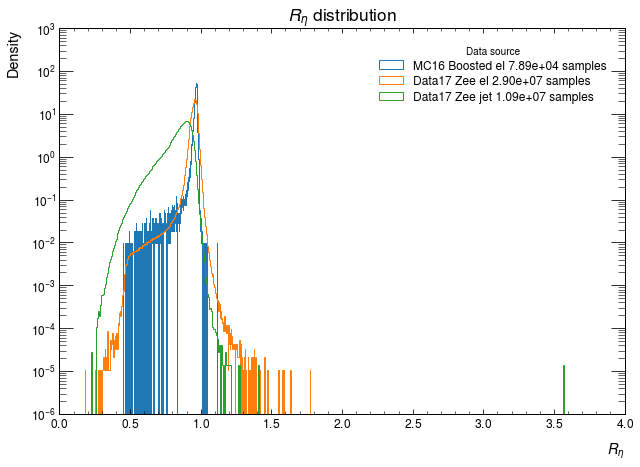

In [101]:
var='reta'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=None, bins=500))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)

ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')

# sub_ax_pos = [0.1, 0.6, 0.42, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))

fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 20:47:21,354 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 20:47:21,430 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 20:47:21,491 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 20:47:21,546 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 20:47:21,612 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 20:47:21,664 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 20:47:21,786 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 20:47:21,919 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 20:47:22,005 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 20:47:22,125 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 20:47:22,183 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 20:47:22,413 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 20:47:22,562 - At bin 12 et_range [30.0, 40.

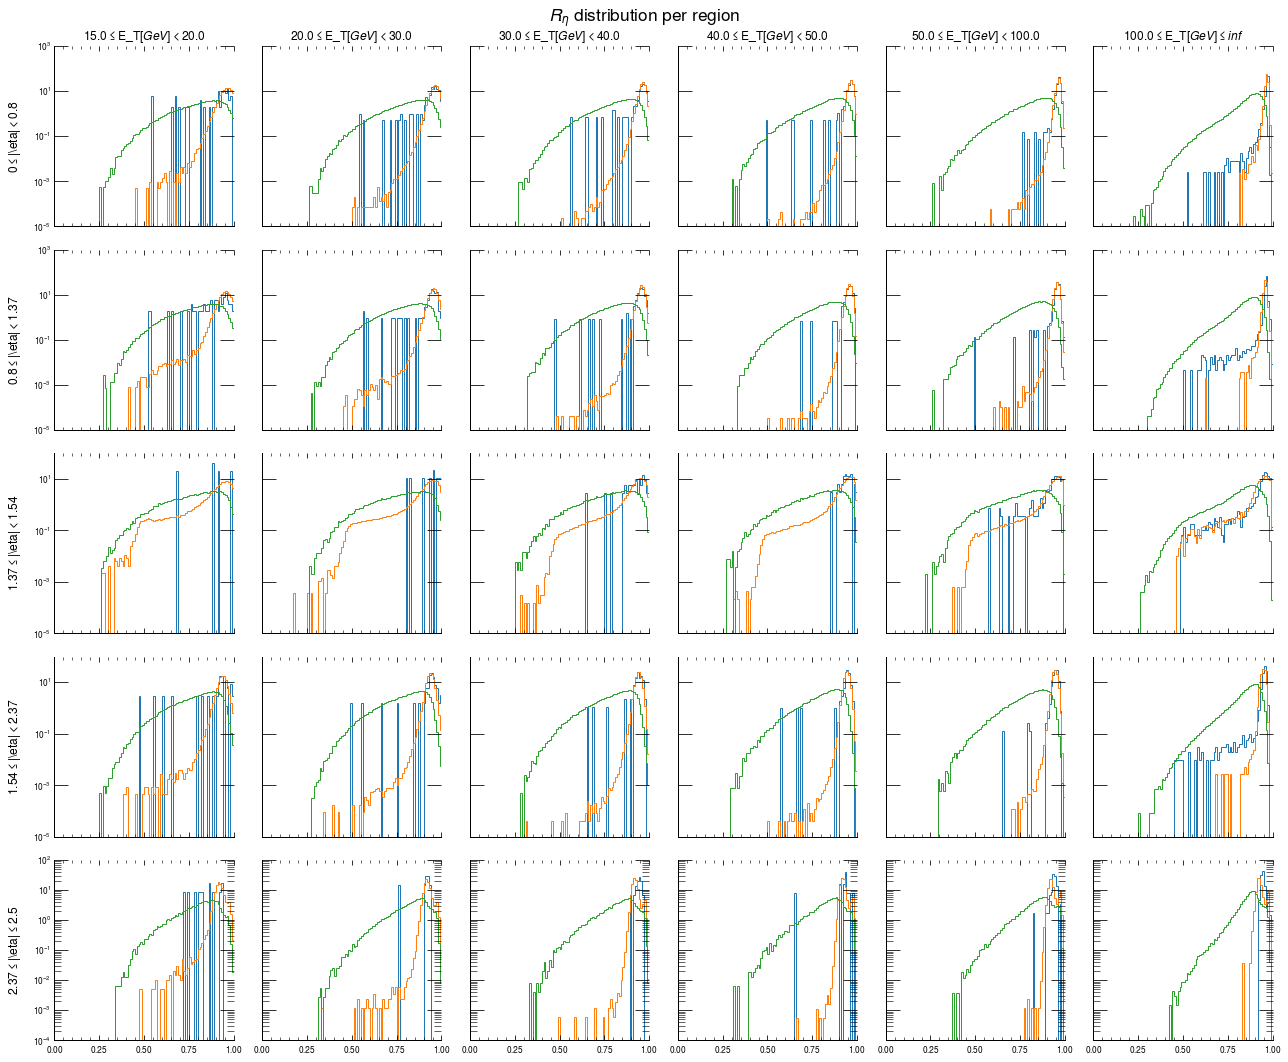

In [56]:
var='reta'
plot_scale = 'log'
params = {
    'MC16 Boosted el':{
        'bins': 100,
        'range':(0,1)
    },
    'Data17 Zee el':{
        'bins': 100,
        'range':(0,1)
    },
    'Data17 Zee jet':{
        'bins': 100,
        'range':(0,1)
    }
}
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $E_{had1}$
No documentation

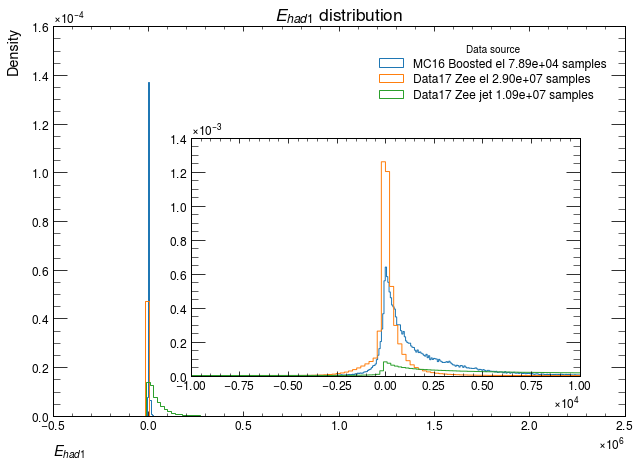

In [154]:
var='ehad1'
var_info = get_var_info(var)
plot_scale = 'linear'
kwargs = dict.fromkeys(data.keys(), dict(range=(None), bins=100))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'], loc='left')
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()
sub_ax_pos = [0.3, 0.2, 0.6, 0.5]
sub_ax = fig.add_axes(sub_ax_pos)
make_hist1d_plot(data, var, sub_ax, **dict.fromkeys(data.keys(), dict(range=(None), bins=10000)))
sub_ax.set(xlim=(-0.1e5, 0.1e5), yscale=plot_scale)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 20:53:20,802 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 20:53:20,883 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 20:53:20,942 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 20:53:20,993 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 20:53:21,055 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 20:53:21,103 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 20:53:21,222 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 20:53:21,310 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 20:53:21,367 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 20:53:21,462 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 20:53:21,519 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 20:53:21,797 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 20:53:21,946 - At bin 12 et_range [30.0, 40.

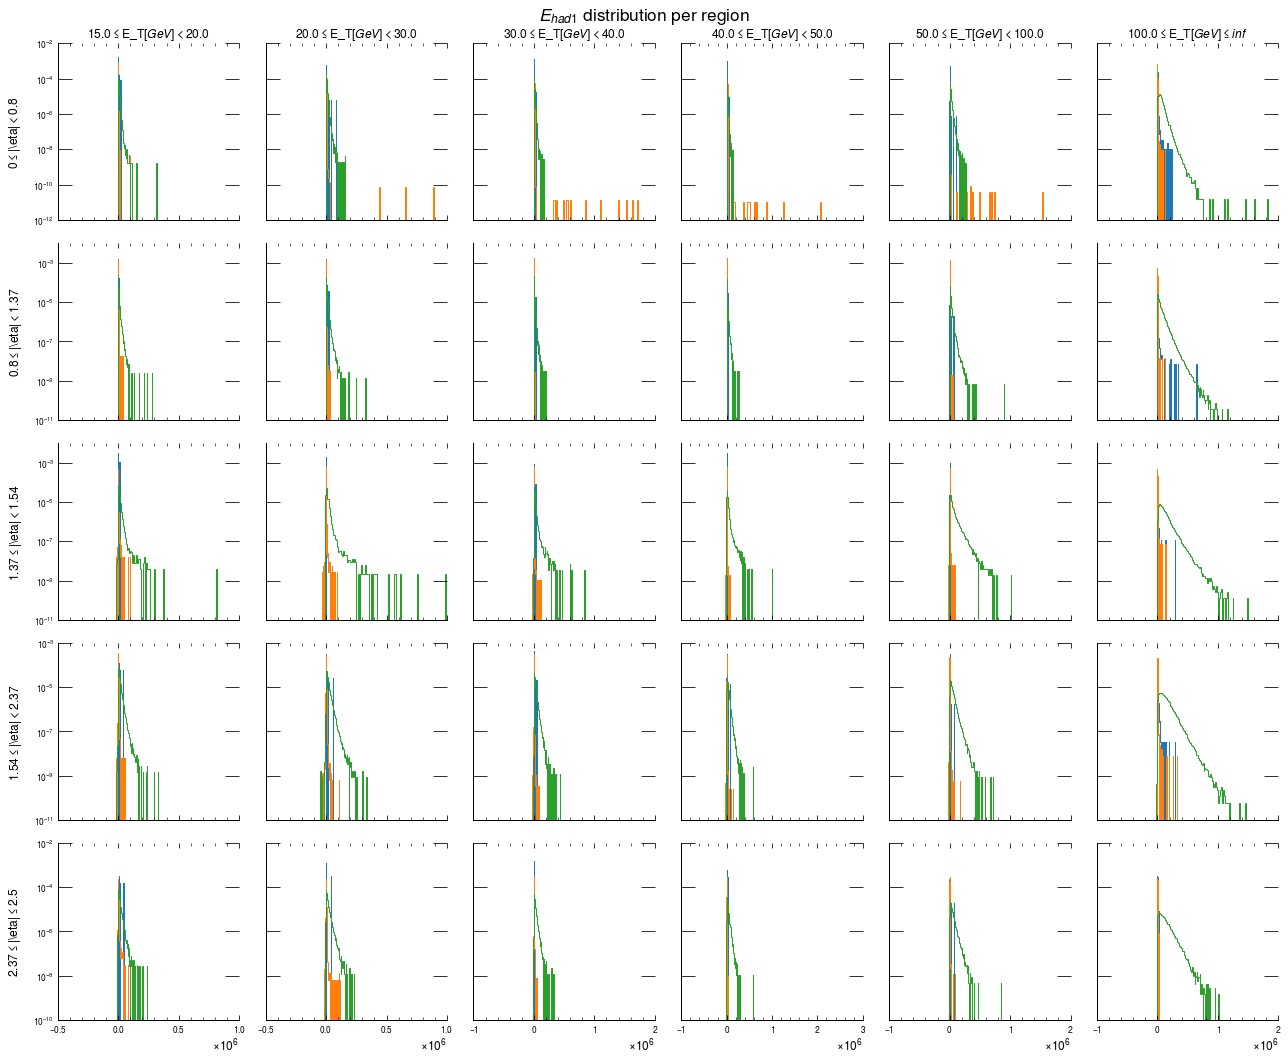

In [63]:
var='ehad1'
plot_scale = 'log'
params = {
    'MC16 Boosted el':{
        'bins': 100,
        'range':None
    },
    'Data17 Zee el':{
        'bins': 100,
        'range':None
    },
    'Data17 Zee jet':{
        'bins': 100,
        'range':None
    }
}
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $f_1$

This shower shape is a ratio between the energy deposited in EM1 over the total energy in the EM layers. This way the shower shape should be limited to the [0,1] interval. All values were in that interval.

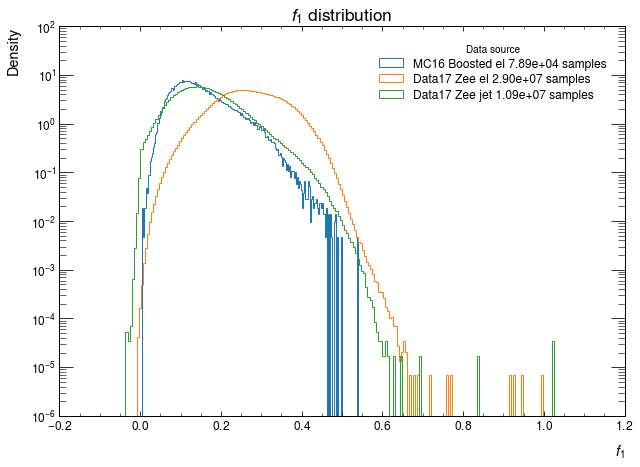

In [105]:
var='f1'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=(None), bins=200))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 21:00:31,299 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 21:00:31,382 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 21:00:31,448 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 21:00:31,519 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 21:00:31,588 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 21:00:31,642 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 21:00:31,776 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 21:00:31,869 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 21:00:31,936 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 21:00:32,043 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 21:00:32,098 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 21:00:32,358 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 21:00:32,510 - At bin 12 et_range [30.0, 40.

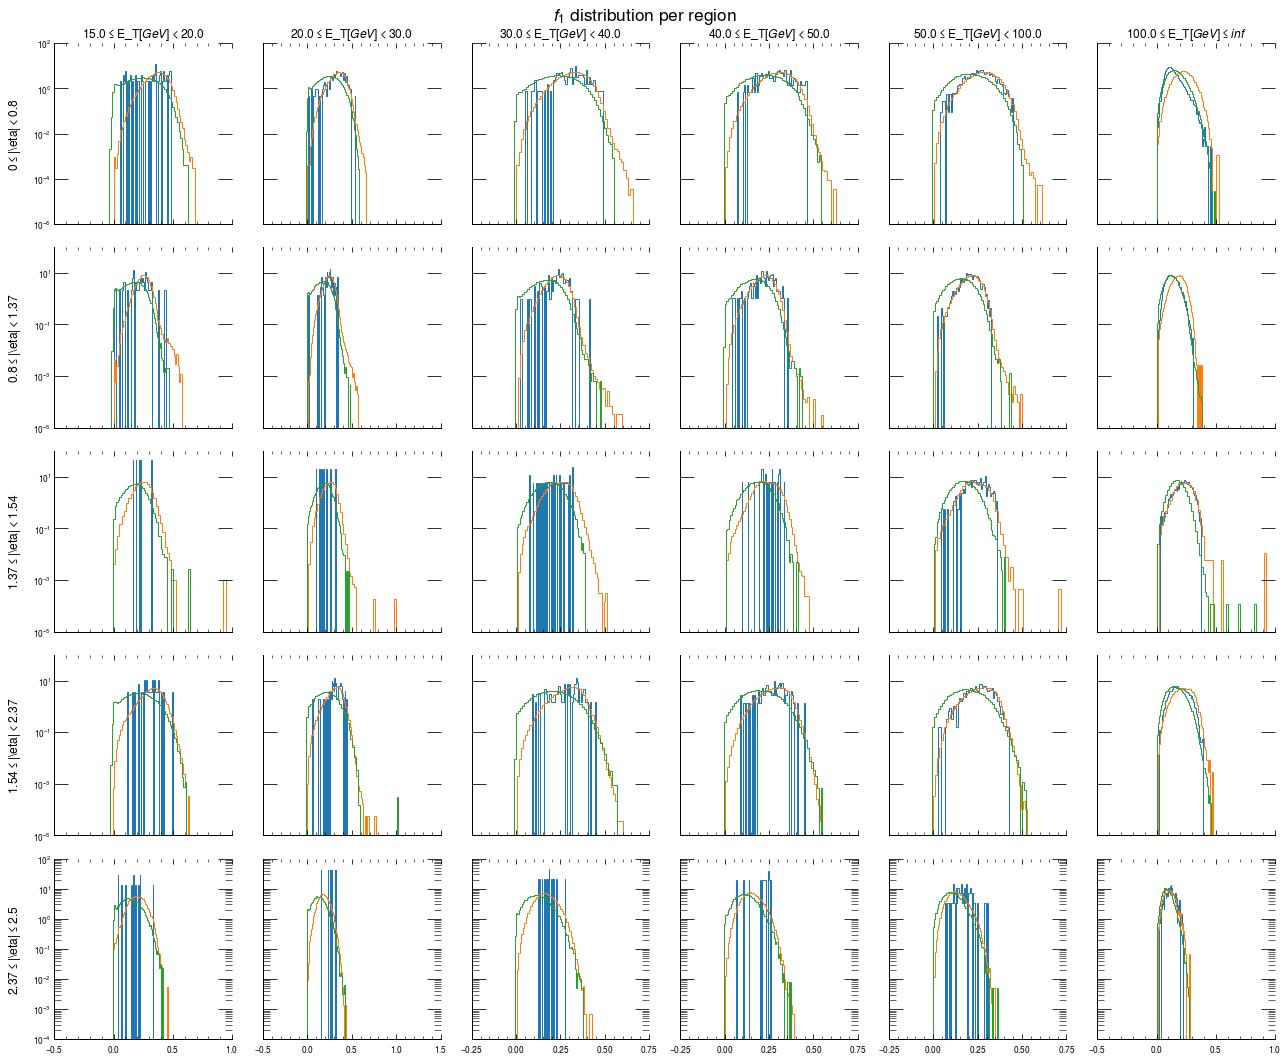

In [73]:
var='f1'
plot_scale = 'log'
params = dict.fromkeys(data.keys(), dict(range=(None), bins=50))
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $f_3$

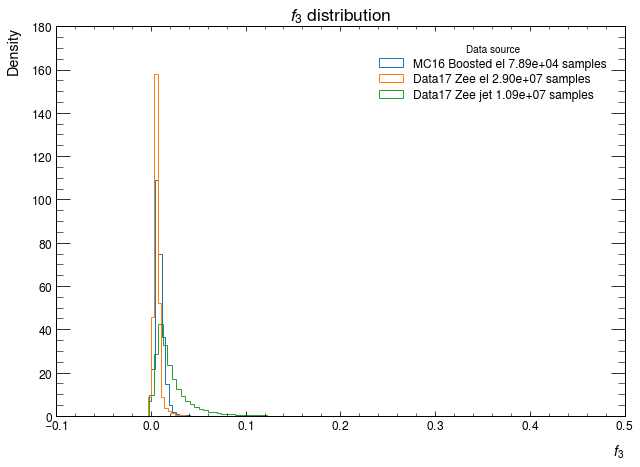

In [107]:
var='f3'
var_info = get_var_info(var)
plot_scale = 'linear'
kwargs = dict.fromkeys(data.keys(), dict(range=(None), bins=100))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 21:09:52,615 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 21:09:52,719 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 21:09:52,778 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 21:09:52,832 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 21:09:52,897 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 21:09:52,950 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 21:09:53,074 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 21:09:53,164 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 21:09:53,226 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 21:09:53,328 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 21:09:53,384 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 21:09:53,619 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 21:09:53,776 - At bin 12 et_range [30.0, 40.

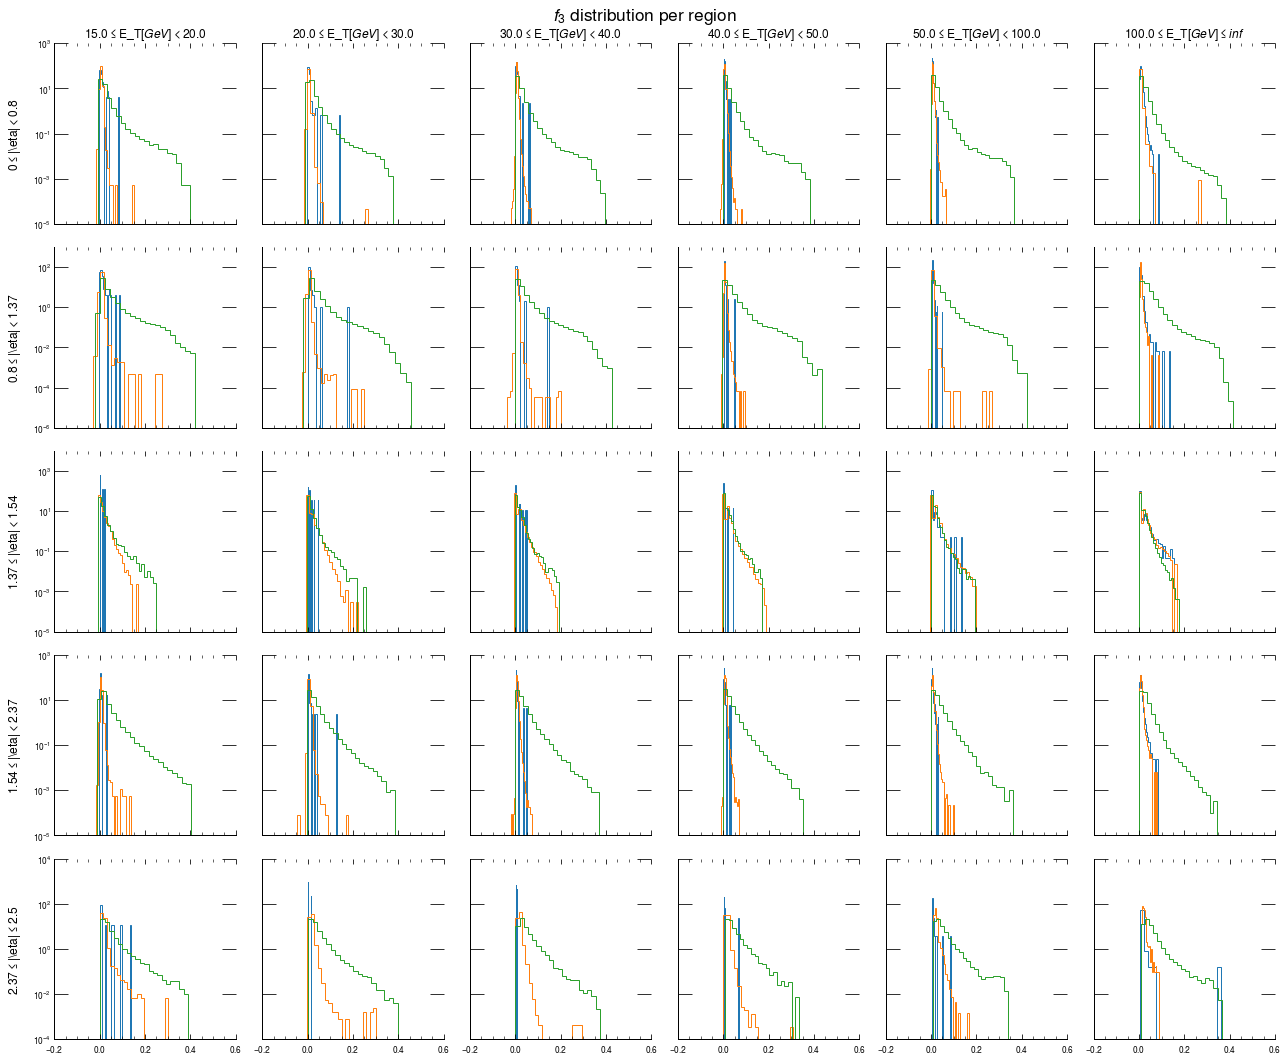

In [78]:
var='f3'
plot_scale = 'log'
params = dict.fromkeys(data.keys(), dict(range=(None), bins=20))
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $\omega_{\eta 2}$
Radial variance of energy deposition in a 3x5 region of EM2 centered in the hottest cell.
Can have multiple values but two modes were identified with the free axis:
- [0, 0.06]: The distributions had different formats
- [98.999, 99]: There was a little number of samples and mostly all of them were 99. As a result of these factors the data between this interval was discarded.

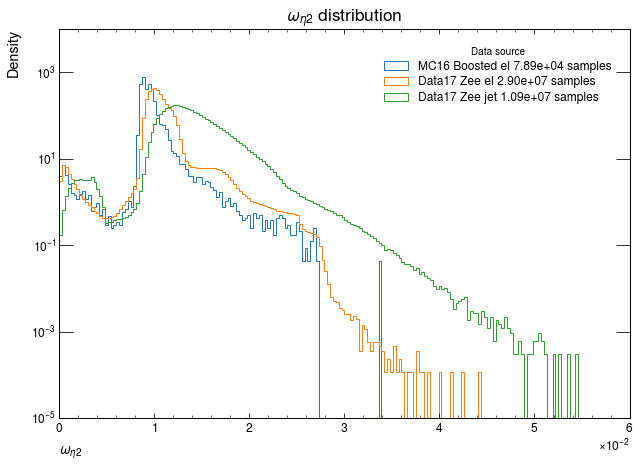

In [110]:
var='weta2'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=(0,0.06), bins=200))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'], loc='left')
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 21:14:08,639 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 21:14:08,752 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 21:14:08,822 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 21:14:08,877 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 21:14:08,941 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 21:14:08,996 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 21:14:09,135 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 21:14:09,234 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 21:14:09,301 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 21:14:09,408 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 21:14:09,470 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 21:14:09,725 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 21:14:09,882 - At bin 12 et_range [30.0, 40.

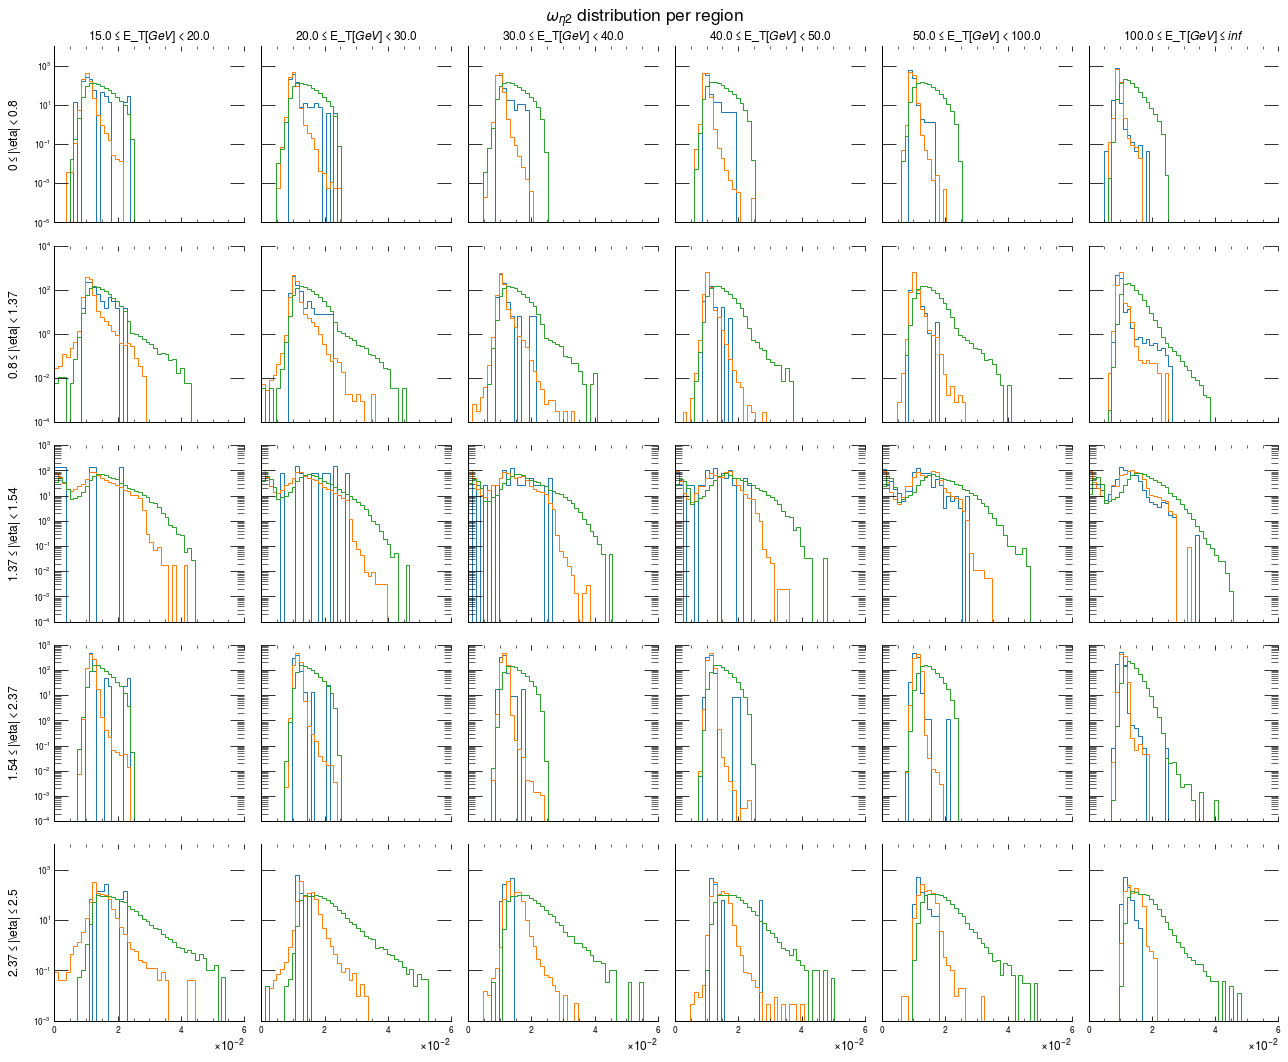

In [83]:
var='weta2'
plot_scale = 'log'
params = dict.fromkeys(data.keys(), dict(range=(0,0.06), bins=50))
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### $w_{stot}$

This shower shape is a root over a squared error, therefore, it cannot be negative. WHen building the histogram with a free range 3 modes were identified:
- -9999: Some samples had this value and were discarded
- [0, 468]: Showed excepted behavior

/tmp/ipykernel_1070/251316372.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


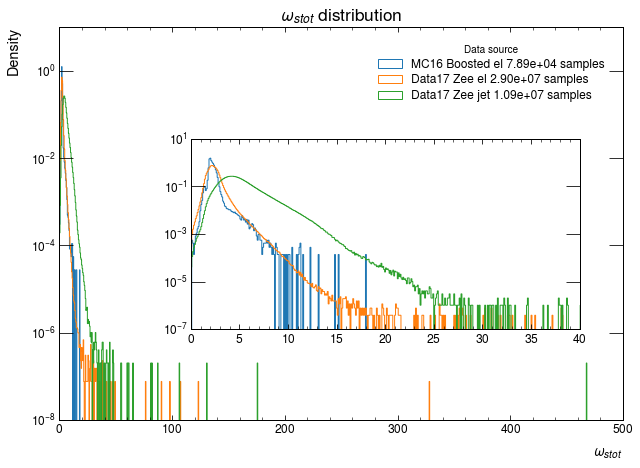

In [124]:
var='wstot'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=(0,468), bins=1000))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
sub_ax_pos = [0.3, 0.3, 0.6, 0.4]
sub_ax = fig.add_axes(sub_ax_pos)
make_hist1d_plot(data, var, sub_ax, **dict.fromkeys(data.keys(), dict(range=(0,468), bins=5000)))
sub_ax.set(xlim=(0,40), yscale=plot_scale)
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
# for key in data_hists.keys():
#     data_hists[key] = get_hist_df(*data_hists[key])
# save_hists_df(data_hists, output_dir, var, 'free_range')

2022-09-21 21:18:41,898 - At bin 0 et_range [15.0, 20.0] eta_range [0, 0.8]
2022-09-21 21:18:41,980 - At bin 1 et_range [15.0, 20.0] eta_range [0.8, 1.37]
2022-09-21 21:18:42,042 - At bin 2 et_range [15.0, 20.0] eta_range [1.37, 1.54]
2022-09-21 21:18:42,097 - At bin 3 et_range [15.0, 20.0] eta_range [1.54, 2.37]
2022-09-21 21:18:42,163 - At bin 4 et_range [15.0, 20.0] eta_range [2.37, 2.5]
2022-09-21 21:18:42,216 - At bin 5 et_range [20.0, 30.0] eta_range [0, 0.8]
2022-09-21 21:18:42,344 - At bin 6 et_range [20.0, 30.0] eta_range [0.8, 1.37]
2022-09-21 21:18:42,441 - At bin 7 et_range [20.0, 30.0] eta_range [1.37, 1.54]
2022-09-21 21:18:42,507 - At bin 8 et_range [20.0, 30.0] eta_range [1.54, 2.37]
2022-09-21 21:18:42,616 - At bin 9 et_range [20.0, 30.0] eta_range [2.37, 2.5]
2022-09-21 21:18:42,681 - At bin 10 et_range [30.0, 40.0] eta_range [0, 0.8]
2022-09-21 21:18:42,965 - At bin 11 et_range [30.0, 40.0] eta_range [0.8, 1.37]
2022-09-21 21:18:43,171 - At bin 12 et_range [30.0, 40.

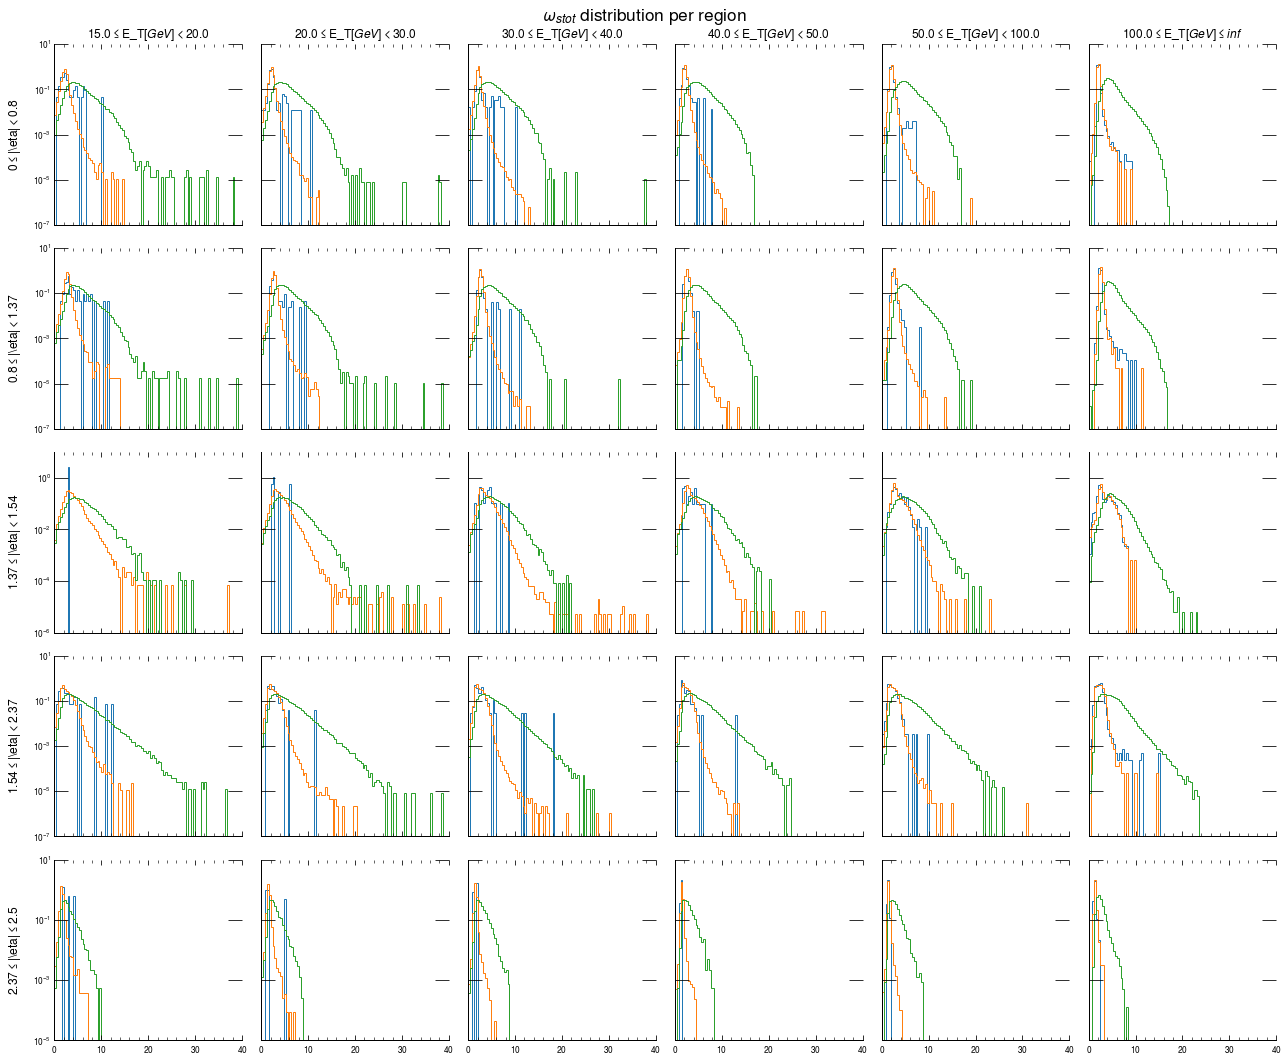

In [95]:
var='wstot'
plot_scale = 'log'
params = dict.fromkeys(data.keys(), dict(range=(0,40), bins=100))
fig, axes = grid_plot(data, var, plot_scale, ET_BINS, ETA_BINS, params)
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_limited_range_{plot_scale}_scale_regions.png'), transparent=False, facecolor='white')

### e2tsts1
For this shower shape there is a peak of negative values between [-999,0]. The name of the col starts with e which may indicate that this value is related to energy. Could not find on my articles what it means.

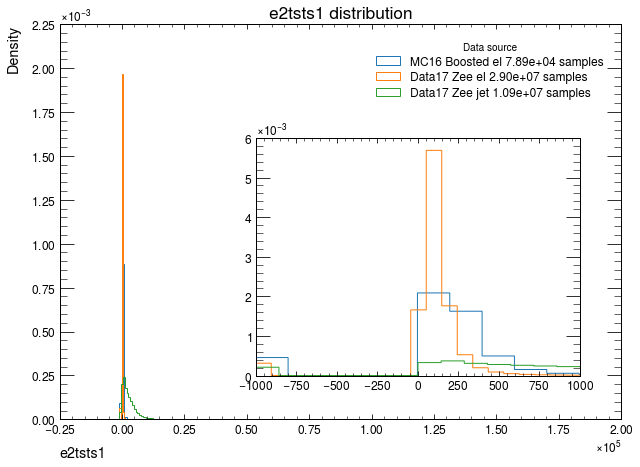

In [137]:
var='e2tsts1'
var_info = get_var_info(var)
plot_scale = 'linear'
kwargs = dict.fromkeys(data.keys(), dict(range=None, bins=200))
fig, ax = plt.subplots(1,1, figsize=(9,6.6), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)

ax.legend(title='Data source')
ax.set_xlabel(var_info['label'], loc='left')
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
fig.tight_layout()

sub_ax_pos = [0.4, 0.2, 0.5, 0.5]
sub_ax = fig.add_axes(sub_ax_pos)
make_hist1d_plot(data, var, sub_ax, **dict.fromkeys(data.keys(), dict(range=None, bins=1000)))
sub_ax.set(xlim=(-0.1e4, 0.1e4), yscale=plot_scale)

fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')

In [131]:
for key in data_hists.keys():
    data_hists[key] = get_hist_df(*data_hists[key])
save_hists_df(data_hists, output_dir, var, 'free_range')

0

### $E_t$

0

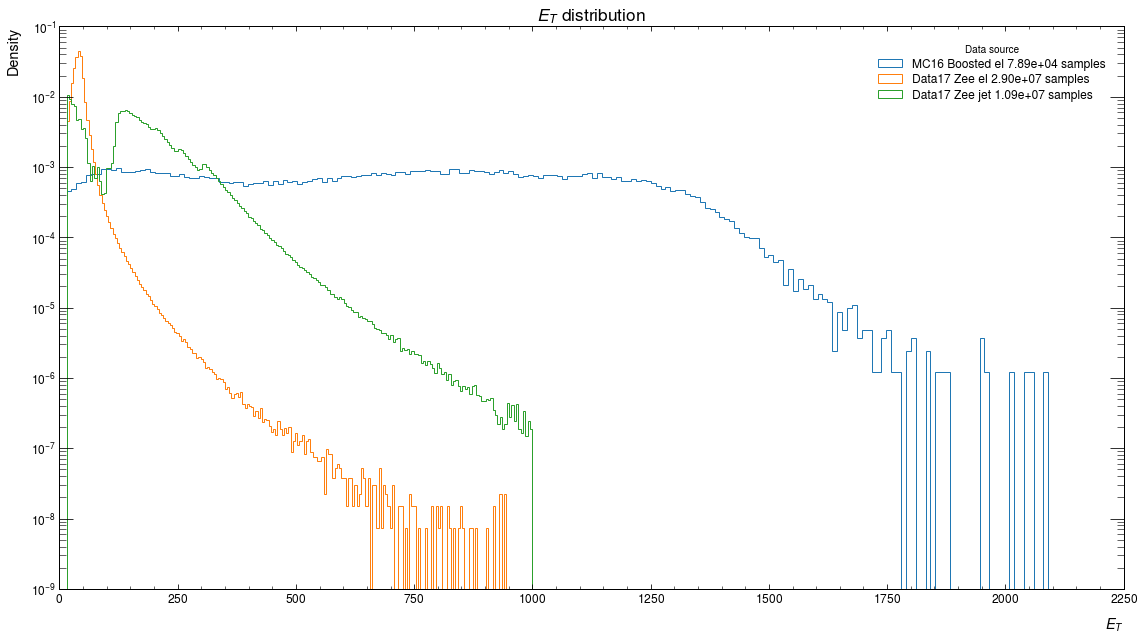

In [96]:
var='et'
var_info = get_var_info(var)
plot_scale = 'log'
kwargs = dict.fromkeys(data.keys(), dict(range=(None), bins=200))
fig, ax = plt.subplots(1,1, figsize=(16,9), dpi=72)
_, data_hists, data_patches = make_hist1d_plot(data, var=var, ax=ax, **kwargs)
ax.legend(title='Data source')
ax.set_xlabel(xlabel=var_info['label'])
ax.set(ylabel='Density', yscale=plot_scale)
ax.set_title(f'{var_info["label"]} distribution', fontsize='xx-large')
# sub_ax_pos = [0.1, 0.6, 0.5, 0.3]
# sub_ax = fig.add_axes(sub_ax_pos)
# make_hist1d_plot(data, var, sub_ax, **kwargs)
# sub_ax.set(xlim=(0.8,1), yscale=plot_scale, ylim=(1e-2, 1e2))
fig.tight_layout()
fig.savefig(os.path.join(output_dir, f'{var_info["name"]}_free_range_{plot_scale}_scale.png'), transparent=False, facecolor='white')
for key in data_hists.keys():
    data_hists[key] = get_hist_df(*data_hists[key])
save_hists_df(data_hists, output_dir, var, 'free_range')

## Joint Plots

In [15]:
plot_scale='linear'
data_to_plot = 'MC16 Boosted el'
x='dr'
y='eratio'
# plot_data = {data_to_plot: boosted_data}
figsize=(16,9)
jgrid = sns.JointGrid(marginal_ticks=True)
x_info = get_var_info(x)
y_info = get_var_info(y)
# x_kwargs = dict.fromkeys(plot_data.keys(), dict(range=None, bins=1000))
# _, x_hists, x_patches = make_hist1d_plot(plot_data, x, jgrid.ax_marg_x, **x_kwargs)
# y_kwargs = dict.fromkeys(plot_data.keys(), dict(range=(0,1), bins=500))
# _, y_hists, y_patches = make_hist1d_plot(plot_data, y, jgrid.ax_marg_y, orientation='horizontal', **y_kwargs)
# cmaps = {key: value for key, value in zip(plot_data.keys(), ['Blues', 'Oranges', 'Greens'])}
plot_logger.info('Plot start')
for source_name, data_source in data.groupby('source'):
    plot_logger.info(f'Plot {source_name}')
    # x_params = x_kwargs[source_name]
    # y_params = y_kwargs[source_name]
    jgrid.ax_marg_x.hist(data_source[x_info['TaP']], bins=1000, density=True, range=None)
    jgrid.ax_marg_y.hist(data_source[y_info['l2calo']], bins=500, density=True, range=(0,1), orientation='horizontal')
    # _, _, _, img = jgrid.ax_joint.hist2d(data_source[x_info['TaP']], data_source[y_info['l2calo']], 
    #                     bins=500, 
    #                     density=True, cmap="icefire_r", cmin=1e-12, 
    #                     range=[x_params['range'], y_params['range']])
    # jgrid.ax_joint.scatter(data_source[x_info['l2calo']], data_source[y_info['l2calo']])
plot_logger.info('Plotted')
cbar_ax = plt.colorbar(img, ax=jgrid.ax_joint, use_gridspec=True, fraction=0.1, label='Density')

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = jgrid.ax_joint.get_position()
pos_marg_x_ax = jgrid.ax_marg_x.get_position()
pos_marg_y_ax = jgrid.ax_marg_y.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
jgrid.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
jgrid.figure.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

jgrid.figure.text(0.7, 0.9, f'Samples:\n{len(data_source)}', fontsize='large',
                    verticalalignment='top', wrap=True)
jgrid.ax_marg_x.set_yscale(plot_scale)
jgrid.ax_marg_x.set_ylabel('Density')
jgrid.ax_marg_y.set_xscale(plot_scale)
jgrid.ax_marg_y.set_xlabel('Density')
jgrid.ax_joint.set(ylim=(0.8,1), xlim=(0,1), xlabel=x_info['label'], ylabel=y_info['label'])
jgrid.figure.suptitle(f'{y_info["label"]} x {x_info["label"]} distribution {data_to_plot}', fontsize='xx-large')
jgrid.figure.set_figwidth(figsize[0])
jgrid.figure.set_figheight(figsize[1])
jgrid.figure.tight_layout()

2022-09-22 21:15:59,468 - Plot start


: 

: 

/tmp/ipykernel_1070/1829505405.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  jgrid.figure.tight_layout()


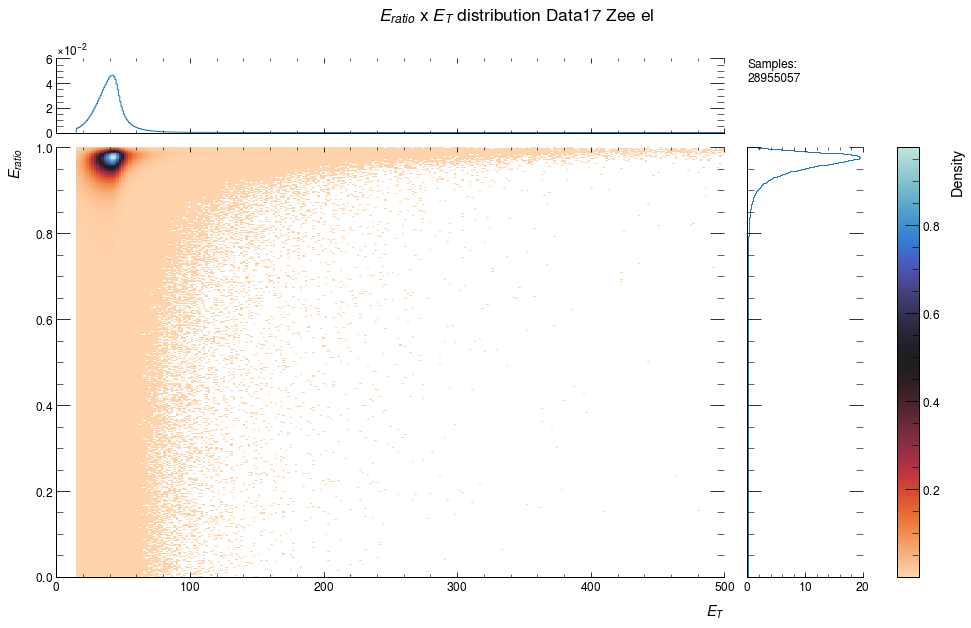

In [60]:
plot_scale='linear'
data_to_plot = 'Data17 Zee el'
x='et'
y='eratio'
plot_data = {data_to_plot: data[data_to_plot]}
figsize=(16,9)
jgrid = sns.JointGrid(marginal_ticks=True)
x_info = get_var_info(x)
y_info = get_var_info(y)
x_kwargs = dict.fromkeys(plot_data.keys(), dict(range=None, bins=1000))
_, x_hists, x_patches = make_hist1d_plot(plot_data, x, jgrid.ax_marg_x, **x_kwargs)
y_kwargs = dict.fromkeys(plot_data.keys(), dict(range=(0,1), bins=500))
_, y_hists, y_patches = make_hist1d_plot(plot_data, y, jgrid.ax_marg_y, orientation='horizontal', **y_kwargs)
cmaps = {key: value for key, value in zip(plot_data.keys(), ['Blues', 'Oranges', 'Greens'])}
for source_name, data_source in plot_data.items():
    x_params = x_kwargs[source_name]
    y_params = y_kwargs[source_name]
    _, _, _, img = jgrid.ax_joint.hist2d(data_source[x_info['l2calo']], data_source[y_info['l2calo']], 
                        bins=500, 
                        density=True, cmap="icefire_r", cmin=1e-12, 
                        range=[x_params['range'], y_params['range']])
    # jgrid.ax_joint.scatter(data_source[x_info['l2calo']], data_source[y_info['l2calo']])

cbar_ax = plt.colorbar(img, ax=jgrid.ax_joint, use_gridspec=True, fraction=0.1, label='Density')

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = jgrid.ax_joint.get_position()
pos_marg_x_ax = jgrid.ax_marg_x.get_position()
pos_marg_y_ax = jgrid.ax_marg_y.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
jgrid.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
jgrid.figure.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

jgrid.figure.text(0.7, 0.9, f'Samples:\n{len(data_source)}', fontsize='large',
                    verticalalignment='top', wrap=True)
jgrid.ax_marg_x.set_yscale(plot_scale)
jgrid.ax_marg_x.set_ylabel('Density')
jgrid.ax_marg_y.set_xscale(plot_scale)
jgrid.ax_marg_y.set_xlabel('Density')
jgrid.ax_joint.set(ylim=(0,1), xlim=(0,500), xlabel=x_info['label'], ylabel=y_info['label'])
jgrid.figure.suptitle(f'{y_info["label"]} x {x_info["label"]} distribution {data_to_plot}', fontsize='xx-large')
jgrid.figure.set_figwidth(figsize[0])
jgrid.figure.set_figheight(figsize[1])
jgrid.figure.tight_layout()

/tmp/ipykernel_1070/2331979882.py:46: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  jgrid.figure.tight_layout()


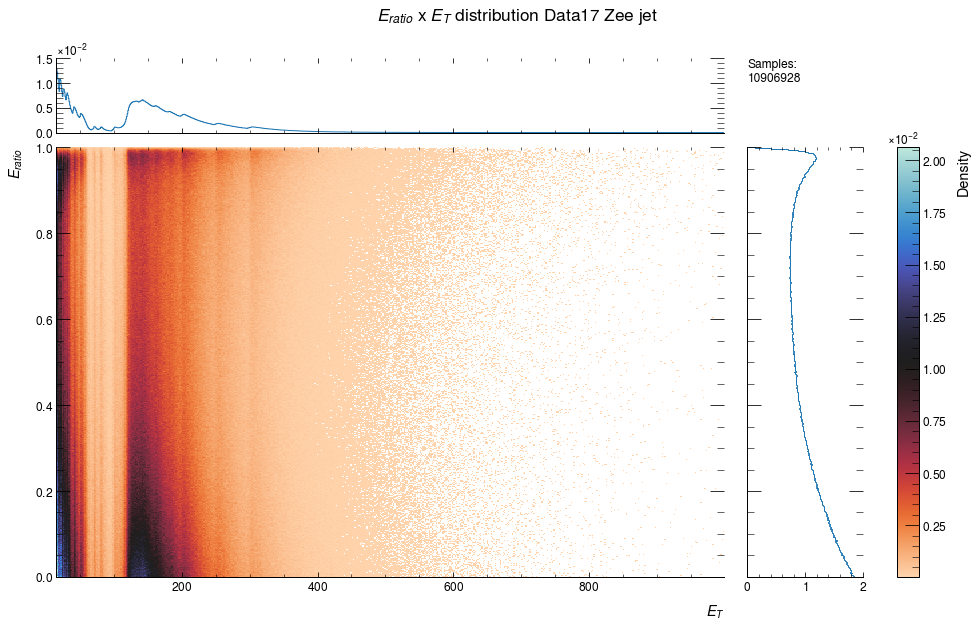

In [62]:
plot_scale='linear'
data_to_plot = 'Data17 Zee jet'
x='et'
y='eratio'
plot_data = {data_to_plot: data[data_to_plot]}
figsize=(16,9)
jgrid = sns.JointGrid(marginal_ticks=True)
x_info = get_var_info(x)
y_info = get_var_info(y)
x_kwargs = dict.fromkeys(plot_data.keys(), dict(range=None, bins=1000))
_, x_hists, x_patches = make_hist1d_plot(plot_data, x, jgrid.ax_marg_x, **x_kwargs)
y_kwargs = dict.fromkeys(plot_data.keys(), dict(range=(0,1), bins=500))
_, y_hists, y_patches = make_hist1d_plot(plot_data, y, jgrid.ax_marg_y, orientation='horizontal', **y_kwargs)
cmaps = {key: value for key, value in zip(plot_data.keys(), ['Blues', 'Oranges', 'Greens'])}
for source_name, data_source in plot_data.items():
    x_params = x_kwargs[source_name]
    y_params = y_kwargs[source_name]
    _, _, _, img = jgrid.ax_joint.hist2d(data_source[x_info['l2calo']], data_source[y_info['l2calo']], 
                        bins=500, 
                        density=True, cmap="icefire_r", cmin=1e-12, 
                        range=[x_params['range'], y_params['range']])
    # jgrid.ax_joint.scatter(data_source[x_info['l2calo']], data_source[y_info['l2calo']])

cbar_ax = plt.colorbar(img, ax=jgrid.ax_joint, use_gridspec=True, fraction=0.1, label='Density')

plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
# get the current positions of the joint ax and the ax for the marginal x
pos_joint_ax = jgrid.ax_joint.get_position()
pos_marg_x_ax = jgrid.ax_marg_x.get_position()
pos_marg_y_ax = jgrid.ax_marg_y.get_position()
# reposition the joint ax so it has the same width as the marginal x ax
jgrid.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# reposition the colorbar using new x positions and y positions of the joint ax
jgrid.figure.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])

jgrid.figure.text(0.7, 0.9, f'Samples:\n{len(data_source)}', fontsize='large',
                    verticalalignment='top', wrap=True)
jgrid.ax_marg_x.set_yscale(plot_scale)
jgrid.ax_marg_x.set_ylabel('Density')
jgrid.ax_marg_y.set_xscale(plot_scale)
jgrid.ax_marg_y.set_xlabel('Density')
jgrid.ax_joint.set(ylim=(0,1), xlim=None, xlabel=x_info['label'], ylabel=y_info['label'])
jgrid.figure.suptitle(f'{y_info["label"]} x {x_info["label"]} distribution {data_to_plot}', fontsize='xx-large')
jgrid.figure.set_figwidth(figsize[0])
jgrid.figure.set_figheight(figsize[1])
jgrid.figure.tight_layout()

## End

In [56]:
plt.close('all')